In [0]:
#

# Colab Setup

In [1]:
# set tensorflow version
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.2.0-rc4'

In [2]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# copy the script file to current folder so it can be imported.
import shutil
import os
original = [
  r'/content/drive/My Drive/time_sequence_alchemy/utils/data_prep.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/model.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/others.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/plot.py',
  r'/content/drive/My Drive/time_sequence_alchemy/log_embeddings_16_sg.txt',
]
target = [
  r'./utils/data_prep.py',
  r'./utils/model.py',
  r'./utils/others.py',
  r'./utils/plot.py',
  r'./log_embeddings_16_sg.txt',
]

if not os.path.exists('./utils'):
  os.makedirs('./utils')

for orig, targ in zip(original, target):
  shutil.copyfile(orig, targ)
  print('Script copied:', targ)


Script copied: ./utils/data_prep.py
Script copied: ./utils/model.py
Script copied: ./utils/others.py
Script copied: ./utils/plot.py
Script copied: ./log_embeddings_16_sg.txt


In [0]:
# data file on Colab
data_fn = r'/content/drive/My Drive/time_sequence_alchemy/data/HDFS/Xy_dataset_120s.pkl'
data_fn = r'/content/drive/My Drive/time_sequence_alchemy/data/HDFS/Xy_dataset.pkl'

In [0]:
from utils.data_prep import tokenize, trim_time_sequence, remove_long_sequence, pad_time_sequence, prepare_dataset_v2
from utils.model import TimeChanger_FFT, TimeChangerLstm, TimeChanger, naive_evaluate, load_embeddings
from utils.model import ResampleLayer
from utils.others import print_train_info_v2, plot_and_save
from utils import plot
import tensorflow as tf
import numpy as np
import pickle
from time import time
from sklearn.metrics import confusion_matrix

# Load Data

In [62]:
TS_LIMIT = 100  # samples will be trimmed/picked within this limit (sec)

# Load data
print('\nLoading data...', end='')
start = time()
with open(data_fn,'rb') as f:
  X, y = pickle.load(f)
print('{:.2f}s\n'.format(time()-start))

# separate value & timestamp
print('\nProcessing data...', end='')
start = time()
x_seq =  X[:, 0]
x_ts = X[:, 1].copy()
# y = y[0:5000]
del X

# tokenization
x_tok, tokenizer = tokenize(x_seq)  # 48 tokens
vocab_size = len(tokenizer.word_counts)
# trim/remove data to a certain time length
# x_tok, x_ts, y = remove_long_sequence(x_tok, x_ts, y, TS_LIMIT)  # remove sequence that are longer than limit
trim_time_sequence(x_tok, x_ts, TS_LIMIT)  # trim sequence to limit
# front pad data to form matrices.
x_tok, x_ts = pad_time_sequence(x_tok, x_ts, 
    maxlen=250, ts_interval=0.1)

print('{:.2f}s\n'.format(time()-start))


Loading data...26.56s


Processing data...142.50s



## Load embeddings
Load the word2vec results. For token 0 (placeholder), set embedding to all 0.

In [63]:
embeddings, embedding_dims = load_embeddings('./log_embeddings_16_sg.txt')
# obtain token - embedding matrix, token zero's embedding is zero.
embedding_matrix = np.zeros((vocab_size+1, embedding_dims))

for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = embeddings[word]

print(embedding_matrix.shape)

vocab_size, embedding_dims: 48 16
(49, 16)


## Make dataset

In [64]:
# make dataset
test_ratio = 0.2
val_ratio = 0.2

# balanced dataset (downsampling)
_train, _val, _test = prepare_dataset_v2(x_tok, x_ts, y, test_ratio=test_ratio, val_ratio=val_ratio)
x_train, ts_train, y_train = _train
x_val, ts_val, y_val = _val
x_test, ts_test, y_test = _test
train_size = len(y_train)
val_size = len(y_val)
test_size = len(y_test)
del _train, _val, _test

# checksum
print('check these values consistent:')
print(y_train[0:20], '\n', y_val[0:20], '\n', y_test[0:20], '\n')

# make train dataset specifically for manual training
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, ts_train, y_train)).batch(batch_size).prefetch(2)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, ts_val, y_val)).batch(batch_size).prefetch(2)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, ts_test, y_test)).batch(batch_size).prefetch(2)

check these values consistent:
[0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0] 
 [1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1] 
 [0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1] 



Check the dataset split is consistent. The first 10 items should be:

Full data
- ```train: [0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0]```
- ```val__: [1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1]```
- ```test_: [0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1]```

# Models w/o timestamps

## Baseline


In [65]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(
    vocab_size+1, embedding_dims,    # +1 because of padding 0
    # embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, input_length=250),  # input_length=input_length
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=32, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid'),
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 250, 16)           784       
_________________________________________________________________
flatten_7 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                256064    
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 258,961
Trainable params: 258,177
Non-trainable params: 784
______________________________________________

### Metrics

In [0]:
# define metrics, to display during training
train_loss = tf.keras.metrics.Mean()
train_metrics = {
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    'precision': tf.keras.metrics.Precision(),
    'recall': tf.keras.metrics.Recall(),
    }
val_metrics = {
    'loss': tf.keras.metrics.Mean(),
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    }
# training history and curve
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

# define other training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)   #Adam, SGD
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Training

In [67]:
# start training
print('Start training with {} samples, validate with {} samples'.format(train_size, val_size))
epochs = 1000   # will run 3 hours worst case.
for epoch in range(epochs):
  start = time()
  
  # reset metrics
  train_loss.reset_states()
  for metric in train_metrics.values():
    metric.reset_states()
  for metric in val_metrics.values():
    metric.reset_states()

  for x_batch, ts_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:     # watch_accessed_variables=False
      y_pred = model(x_batch)  # ((x_batch, ts_batch))
      y_pred = tf.squeeze(y_pred, 1)   # make it same dimension as y

      # Loss value for this minibatch
      loss = loss_fn(y_batch, y_pred)
      loss += sum(model.losses)  # must have, what does this do?
      
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update metrics
    train_loss.update_state(loss)
    for metric in train_metrics.values():
        metric.update_state(y_batch, y_pred)
    # print('~', end='')
  
  # update val metrics
  if val_size != 0:
    for x_batch, ts_batch, y_batch in val_dataset:
      y_val_pred = model(x_batch)
      y_val_pred = tf.squeeze(y_val_pred, 1)
      loss = loss_fn(y_batch, y_val_pred)
      val_metrics['loss'].update_state(loss)
      val_metrics['accuracy'].update_state(y_batch, y_val_pred)
  
  # log 
  history['train_loss'].append(train_loss.result().numpy())
  history['train_acc'].append(train_metrics['accuracy'].result().numpy())
  history['val_loss'].append(val_metrics['loss'].result().numpy())
  history['val_acc'].append(val_metrics['accuracy'].result().numpy())

  print_train_info_v2(epoch, time()-start, history)

  # determine early stopping
  # sometimes the loss goes up for a short period, do nothing and wait.
  # stops only when it's absolutely flat.
  
  w = 10     # early stopping moving average window
  n = 5     # early stopping hesitate epochs
  thres = 0.0002        # loss difference threshold
  acc_thres = 0.6   # absolute loss threshold

  if epoch >= n+w+1:
    # loss moving average of the last few epochs
    loss_MA = [history['train_loss'][i-w:i] for i in range(epoch-n, epoch+1)]
    loss_MA = [sum(values) / w for values in loss_MA]
    acc_MA = [history['train_acc'][i-w:i] for i in range(epoch-n, epoch+1)]
    acc_MA = [sum(values) / w for values in acc_MA]
    # for the last n losses, must be going down, and diff < thres
    train_stopping = [abs(a-b)<=thres for (a,b) in zip(loss_MA[0:-1], loss_MA[1:])]
    if sum(train_stopping) == n and acc_MA[-1] >= acc_thres:
      print('Early stopping triggered.')
      print_train_info_v2(epoch, time()-start, history)
      break
  
  # save weights every epoch
  if epoch % 10 == 0: model.save_weights('./checkpoints/my_checkpoint')

Start training with 21552 samples, validate with 5388 samples
epoch 0 - 2s. train_loss: 0.6929 train_acc: 50.14% val_loss: 0.6833 val_acc: 50.00% 
epoch 1 - 2s. train_loss: 0.6401 train_acc: 64.68% val_loss: 0.6070 val_acc: 73.69% 
epoch 2 - 2s. train_loss: 0.6007 train_acc: 75.47% val_loss: 0.5997 val_acc: 74.95% 
epoch 3 - 2s. train_loss: 0.5970 train_acc: 76.15% val_loss: 0.5971 val_acc: 75.96% 
epoch 4 - 2s. train_loss: 0.5957 train_acc: 76.48% val_loss: 0.5960 val_acc: 76.46% 
epoch 5 - 2s. train_loss: 0.5948 train_acc: 76.78% val_loss: 0.5954 val_acc: 77.18% 
epoch 6 - 2s. train_loss: 0.5935 train_acc: 77.29% val_loss: 0.5942 val_acc: 77.24% 
epoch 7 - 2s. train_loss: 0.5926 train_acc: 77.52% val_loss: 0.5934 val_acc: 77.38% 
epoch 8 - 2s. train_loss: 0.5921 train_acc: 77.65% val_loss: 0.5928 val_acc: 77.78% 
epoch 9 - 2s. train_loss: 0.5917 train_acc: 77.71% val_loss: 0.5923 val_acc: 77.79% 
epoch 10 - 2s. train_loss: 0.5915 train_acc: 77.75% val_loss: 0.5920 val_acc: 77.79% 
ep

### Evaluation

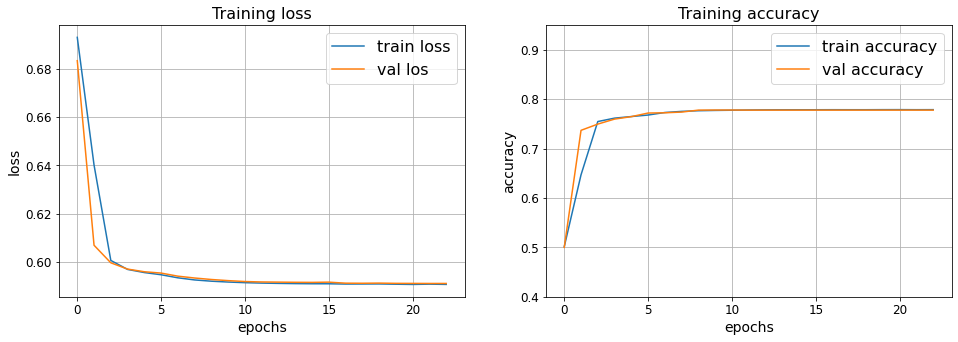

In [68]:
# Training curve
plot.dual_train_curve(history['train_loss'], history['val_loss'], 
      history['train_acc'], history['val_acc'])

In [69]:
print('Evaluation on train dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, train_dataset)
print('Evaluation on val dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, val_dataset)
print('Evaluation on test dataset:')
(te_acc, te_p, te_r) = naive_evaluate(model, test_dataset)

print('\nFor logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r')
print(len(history['train_loss']), history['train_loss'][-1],tr_acc, tr_p, tr_r, te_acc, te_p, te_r)

Evaluation on train dataset:
Acc: 77.87%, P: 95.57%, R: 58.47%
Evaluation on val dataset:
Acc: 77.78%, P: 94.97%, R: 58.13%
Evaluation on test dataset:
Acc: 77.23%, P: 94.87%, R: 57.63%

For logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r
23 0.5907692 0.77775806 0.94966644 0.58129174 0.77230906 0.94868034 0.5763064


### Eval in detail

Converted P/R. 

In [70]:
from sklearn import metrics
print('Test data shape:',x_test.shape, y_test.shape)
# confusion matrix
faulty_thres = 0.5

y_prob = model((x_test, ts_test)).numpy()
y_pred = y_prob >= faulty_thres
result = [a==b for a,b in zip(y_pred, y_test)]
print('At threshold {}, accuracy: {:.2%}'.format(faulty_thres, metrics.accuracy_score(y_test, y_prob >= faulty_thres)))
conf_mtx = confusion_matrix(y_test, y_pred)
conf_mtx

Test data shape: (6736, 250) (6736,)
At threshold 0.5, accuracy: 77.26%


array([[3263,  105],
       [1427, 1941]])

In [71]:
# convert to real world scale

fault_ratio = 16838/575061     # faulty rate in real world
real_n = 575061       # total sample in real dataset
real_1 = 16838
real_0 = real_n - real_1
conf_mtx_cvt = np.zeros([2,2])
conf_mtx_cvt[0,0] = real_0 / (conf_mtx[0,0] + conf_mtx[0,1]) * conf_mtx[0,0]
conf_mtx_cvt[0,1] = real_0 / (conf_mtx[0,0] + conf_mtx[0,1]) * conf_mtx[0,1]
conf_mtx_cvt[1,0] = real_1 / (conf_mtx[1,0] + conf_mtx[1,1]) * conf_mtx[1,0]
conf_mtx_cvt[1,1] = real_1 / (conf_mtx[1,0] + conf_mtx[1,1]) * conf_mtx[1,1]

acc = (conf_mtx_cvt[0,0] + conf_mtx_cvt[1,1]) / conf_mtx_cvt.sum()
p = conf_mtx_cvt[1,1] / (conf_mtx_cvt[0,1] + conf_mtx_cvt[1,1])
r = conf_mtx_cvt[1,1] / (conf_mtx_cvt[1,0] + conf_mtx_cvt[1,1])
print('Converted acc, precision, recall: {:.2%}, {:.2%}, {:.2%}'.format(acc,p,r))

conf_mtx_cvt.round().astype('int')


Converted acc, precision, recall: 95.73%, 35.80%, 57.63%


array([[540820,  17403],
       [  7134,   9704]])

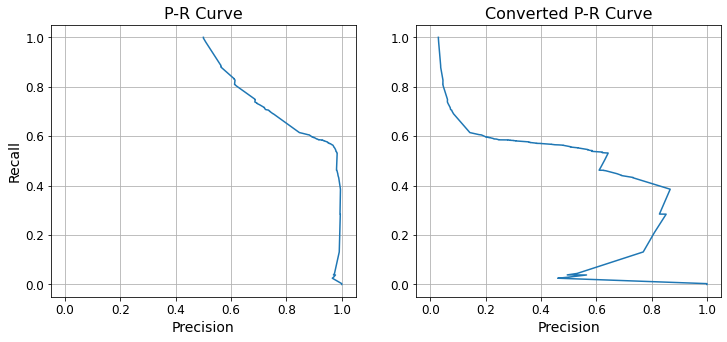

In [0]:
from sklearn.metrics import precision_recall_curve
pr, rc, thresholds = precision_recall_curve(y_test, y_prob, pos_label=1)

# Calculate converted metrics, the mathy way
k = 558223/16838
pr_cvrt = []
for p in pr:
  pr_cvrt.append(1/(k*(1/p-1)+1))
pr_cvrt = np.array(pr_cvrt)

# Converted P-R curve
plot.dual_pr_curve(pr, rc, pr_cvrt, rc)

## Full CNN model

In [72]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(
    vocab_size+1, embedding_dims,    # +1 because of padding 0
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, input_length=250),  # input_length=input_length
  tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=1),
  #tf.keras.layers.GlobalMaxPool1D(),
  tf.keras.layers.MaxPool1D(pool_size=2),
  tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=1),
  tf.keras.layers.MaxPool1D(pool_size=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=32, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid'),
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 250, 16)           784       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 247, 32)           2080      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 123, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 120, 32)           4128      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 60, 32)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)              

### Metrics

Hyper parameters: Adam/RMSprop/..., learning_rate

In [0]:
# define metrics, to display during training
train_loss = tf.keras.metrics.Mean()
train_metrics = {
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    'precision': tf.keras.metrics.Precision(),
    'recall': tf.keras.metrics.Recall(),
    }
val_metrics = {
    'loss': tf.keras.metrics.Mean(),
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    }
# training history and curve
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

# define other training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)   #Adam, SGD
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Training

Hyper parameters: early stopping threshold, accuracy threshold.

In [74]:
# start training
print('Start training with {} samples, validate with {} samples'.format(train_size, val_size))
epochs = 1000   # will run 3 hours worst case.
for epoch in range(epochs):
  start = time()
  
  # reset metrics
  train_loss.reset_states()
  for metric in train_metrics.values():
    metric.reset_states()
  for metric in val_metrics.values():
    metric.reset_states()

  for x_batch, ts_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:     # watch_accessed_variables=False
      y_pred = model(x_batch)  # ((x_batch, ts_batch))
      y_pred = tf.squeeze(y_pred, 1)   # make it same dimension as y

      # Loss value for this minibatch
      loss = loss_fn(y_batch, y_pred)
      loss += sum(model.losses)  # must have, what does this do?
      
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update metrics
    train_loss.update_state(loss)
    for metric in train_metrics.values():
        metric.update_state(y_batch, y_pred)
    # print('~', end='')
  
  # update val metrics
  if val_size != 0:
    for x_batch, ts_batch, y_batch in val_dataset:
      y_val_pred = model(x_batch)
      y_val_pred = tf.squeeze(y_val_pred, 1)
      loss = loss_fn(y_batch, y_val_pred)
      val_metrics['loss'].update_state(loss)
      val_metrics['accuracy'].update_state(y_batch, y_val_pred)
  
  # log 
  history['train_loss'].append(train_loss.result().numpy())
  history['train_acc'].append(train_metrics['accuracy'].result().numpy())
  history['val_loss'].append(val_metrics['loss'].result().numpy())
  history['val_acc'].append(val_metrics['accuracy'].result().numpy())

  print_train_info_v2(epoch, time()-start, history)

  # determine early stopping
  # sometimes the loss goes up for a short period, do nothing and wait.
  # stops only when it's absolutely flat.
  
  w = 10     # early stopping moving average window
  n = 5     # early stopping hesitate epochs
  thres = 0.0001        # loss difference threshold
  acc_thres = 0.75   # absolute loss threshold

  if epoch >= n+w+1:
    # loss moving average of the last few epochs
    loss_MA = [history['train_loss'][i-w:i] for i in range(epoch-n, epoch+1)]
    loss_MA = [sum(values) / w for values in loss_MA]
    acc_MA = [history['train_acc'][i-w:i] for i in range(epoch-n, epoch+1)]
    acc_MA = [sum(values) / w for values in acc_MA]
    # for the last n losses, must be going down, and diff < thres
    train_stopping = [abs(a-b)<=thres for (a,b) in zip(loss_MA[0:-1], loss_MA[1:])]
    if sum(train_stopping) == n and acc_MA[-1] >= acc_thres:
      print('Early stopping triggered.')
      print_train_info_v2(epoch, time()-start, history)
      break
  
  # save weights every epoch
  if epoch % 10 == 0: model.save_weights('./checkpoints/my_checkpoint')
model.save_weights('./checkpoints/my_checkpoint')

Start training with 21552 samples, validate with 5388 samples
epoch 0 - 2s. train_loss: 0.6137 train_acc: 71.88% val_loss: 0.5928 val_acc: 77.56% 
epoch 1 - 2s. train_loss: 0.5917 train_acc: 77.69% val_loss: 0.5915 val_acc: 77.69% 
epoch 2 - 2s. train_loss: 0.5910 train_acc: 77.82% val_loss: 0.5913 val_acc: 77.79% 
epoch 3 - 2s. train_loss: 0.5909 train_acc: 77.86% val_loss: 0.5912 val_acc: 77.79% 
epoch 4 - 2s. train_loss: 0.5909 train_acc: 77.86% val_loss: 0.5912 val_acc: 77.79% 
epoch 5 - 2s. train_loss: 0.5908 train_acc: 77.85% val_loss: 0.5914 val_acc: 77.79% 
epoch 6 - 2s. train_loss: 0.5909 train_acc: 77.86% val_loss: 0.5914 val_acc: 77.81% 
epoch 7 - 2s. train_loss: 0.5907 train_acc: 77.86% val_loss: 0.5911 val_acc: 77.79% 
epoch 8 - 2s. train_loss: 0.5907 train_acc: 77.87% val_loss: 0.5910 val_acc: 77.81% 
epoch 9 - 2s. train_loss: 0.5906 train_acc: 77.89% val_loss: 0.5910 val_acc: 77.81% 
epoch 10 - 2s. train_loss: 0.5906 train_acc: 77.89% val_loss: 0.5911 val_acc: 77.79% 
ep

### Evaluation

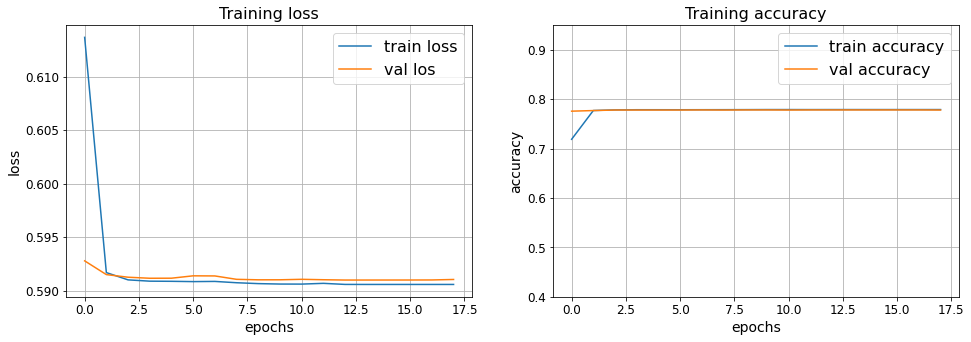

In [75]:
# Training curve
import matplotlib.pyplot as plt
plot.dual_train_curve(history['train_loss'], history['val_loss'], 
      history['train_acc'], history['val_acc'])

In [76]:
print('Evaluation on train dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, train_dataset)
print('Evaluation on val dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, val_dataset)
print('Evaluation on test dataset:')
(te_acc, te_p, te_r) = naive_evaluate(model, test_dataset)

print('\nFor logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r')
print(len(history['train_loss']), history['train_loss'][-1],tr_acc, tr_p, tr_r, te_acc, te_p, te_r)

Evaluation on train dataset:
Acc: 77.89%, P: 95.63%, R: 58.46%
Evaluation on val dataset:
Acc: 77.79%, P: 94.97%, R: 58.17%
Evaluation on test dataset:
Acc: 77.27%, P: 94.96%, R: 57.66%

For logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r
18 0.5905841 0.7779356 0.94969696 0.58166295 0.7727431 0.94963324 0.57660335


### Eval in detail

Converted P/R. 

In [77]:
from sklearn import metrics
print('Test data shape:',x_test.shape, y_test.shape)
# confusion matrix
faulty_thres = 0.5

y_prob = model((x_test, ts_test)).numpy()
y_pred = y_prob >= faulty_thres
result = [a==b for a,b in zip(y_pred, y_test)]
print('At threshold {}, accuracy: {:.2%}'.format(faulty_thres, metrics.accuracy_score(y_test, y_prob >= faulty_thres)))
conf_mtx = confusion_matrix(y_test, y_pred)
conf_mtx

Test data shape: (6736, 250) (6736,)
At threshold 0.5, accuracy: 77.30%


array([[3265,  103],
       [1426, 1942]])

In [78]:
# convert to real world scale

fault_ratio = 16838/575061     # faulty rate in real world
real_n = 575061       # total sample in real dataset
real_1 = 16838
real_0 = real_n - real_1
conf_mtx_cvt = np.zeros([2,2])
conf_mtx_cvt[0,0] = real_0 / (conf_mtx[0,0] + conf_mtx[0,1]) * conf_mtx[0,0]
conf_mtx_cvt[0,1] = real_0 / (conf_mtx[0,0] + conf_mtx[0,1]) * conf_mtx[0,1]
conf_mtx_cvt[1,0] = real_1 / (conf_mtx[1,0] + conf_mtx[1,1]) * conf_mtx[1,0]
conf_mtx_cvt[1,1] = real_1 / (conf_mtx[1,0] + conf_mtx[1,1]) * conf_mtx[1,1]

acc = (conf_mtx_cvt[0,0] + conf_mtx_cvt[1,1]) / conf_mtx_cvt.sum()
p = conf_mtx_cvt[1,1] / (conf_mtx_cvt[0,1] + conf_mtx_cvt[1,1])
r = conf_mtx_cvt[1,1] / (conf_mtx_cvt[1,0] + conf_mtx_cvt[1,1])
print('Converted acc, precision, recall: {:.2%}, {:.2%}, {:.2%}'.format(acc,p,r))

conf_mtx_cvt.round().astype('int')


Converted acc, precision, recall: 95.79%, 36.25%, 57.66%


array([[541151,  17072],
       [  7129,   9709]])

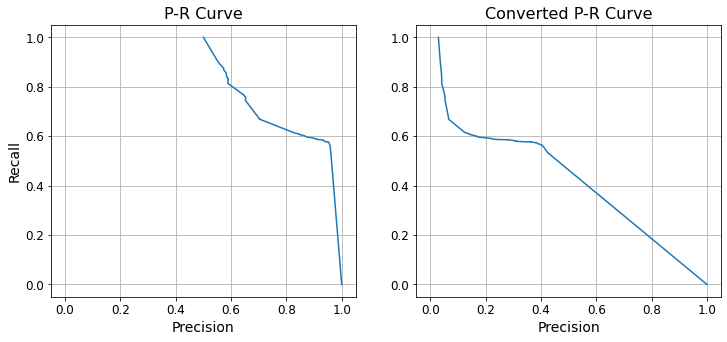

In [79]:
from sklearn.metrics import precision_recall_curve
pr, rc, thresholds = precision_recall_curve(y_test, y_prob, pos_label=1)

# Calculate converted metrics, the mathy way
k = 558223/16838
pr_cvrt = []
for p in pr:
  pr_cvrt.append(1/(k*(1/p-1)+1))
pr_cvrt = np.array(pr_cvrt)

# Converted P-R curve
plot.dual_pr_curve(pr, rc, pr_cvrt, rc)

## Full RNN Model

In [80]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(
    vocab_size+1, embedding_dims,    # +1 because of padding 0
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, input_length=250),  # input_length=input_length
  tf.keras.layers.LSTM(units=64, return_sequences=True),
  tf.keras.layers.LSTM(units=32, return_sequences=False),
  tf.keras.layers.Dense(units=32, activation='tanh'),
  tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 16)           784       
_________________________________________________________________
lstm_3 (LSTM)                (None, 250, 64)           20736     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_31 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 35,025
Trainable params: 34,241
Non-trainable params: 784
_________________________________________________________________


### Metrics

Hyper parameters: Adam/RMSprop/..., learning_rate.  RNN seems to prefer RSMprop.


In [0]:
# define metrics, to display during training
train_loss = tf.keras.metrics.Mean()
train_metrics = {
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    'precision': tf.keras.metrics.Precision(),
    'recall': tf.keras.metrics.Recall(),
    }
val_metrics = {
    'loss': tf.keras.metrics.Mean(),
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    }
# training history and curve
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

# define other training parameters
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)   #Adam, SGD
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Training

Hyper parameters: early stopping threshold, accuracy threshold.

RMSprop is bumpy, set a longer window and larger threshold.

In [82]:
# start training
print('Start training with {} samples, validate with {} samples'.format(train_size, val_size))
epochs = 1000   # will run 3 hours worst case.
for epoch in range(epochs):
  start = time()
  
  # reset metrics
  train_loss.reset_states()
  for metric in train_metrics.values():
    metric.reset_states()
  for metric in val_metrics.values():
    metric.reset_states()

  for x_batch, ts_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:     # watch_accessed_variables=False
      y_pred = model(x_batch)  # ((x_batch, ts_batch))
      y_pred = tf.squeeze(y_pred, 1)   # make it same dimension as y

      # Loss value for this minibatch
      loss = loss_fn(y_batch, y_pred)
      loss += sum(model.losses)  # must have, what does this do?
      
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update metrics
    train_loss.update_state(loss)
    for metric in train_metrics.values():
        metric.update_state(y_batch, y_pred)
    # print('~', end='')
  
  # update val metrics
  for x_batch, ts_batch, y_batch in val_dataset:
    y_val_pred = model(x_batch)
    y_val_pred = tf.squeeze(y_val_pred, 1)
    loss = loss_fn(y_batch, y_val_pred)
    val_metrics['loss'].update_state(loss)
    val_metrics['accuracy'].update_state(y_batch, y_val_pred)

  # log 
  history['train_loss'].append(train_loss.result().numpy())
  history['train_acc'].append(train_metrics['accuracy'].result().numpy())
  history['val_loss'].append(val_metrics['loss'].result().numpy())
  history['val_acc'].append(val_metrics['accuracy'].result().numpy())

  print_train_info_v2(epoch, time()-start, history)

  # determine early stopping
  # sometimes the loss goes up for a short period, do nothing and wait.
  # stops only when it's absolutely flat.
  
  w = 10     # early stopping moving average window
  n = 5     # early stopping hesitate epochs
  thres = 0.0002        # loss difference threshold
  acc_thres = 0.75   # absolute loss threshold

  if epoch >= n+w+1:
    # loss moving average of the last few epochs
    loss_MA = [history['val_loss'][i-w:i] for i in range(epoch-n, epoch+1)]
    loss_MA = [sum(values) / w for values in loss_MA]
    acc_MA = [history['val_acc'][i-w:i] for i in range(epoch-n, epoch+1)]
    acc_MA = [sum(values) / w for values in acc_MA]
    # for the last n losses, must be going down, and diff < thres
    train_stopping = [abs(a-b)<=thres for (a,b) in zip(loss_MA[0:-1], loss_MA[1:])]
    if sum(train_stopping) == n and acc_MA[-1] >= acc_thres:
      print('Early stopping triggered.')
      print_train_info_v2(epoch, time()-start, history)
      break
  
  # save weights every epoch
  if epoch % 10 == 0: model.save_weights('./checkpoints/my_checkpoint')
model.save_weights('./checkpoints/my_checkpoint')

Start training with 21552 samples, validate with 5388 samples
epoch 0 - 4s. train_loss: 0.6724 train_acc: 62.38% val_loss: 0.7022 val_acc: 50.00% 
epoch 1 - 4s. train_loss: 0.6534 train_acc: 64.21% val_loss: 0.6199 val_acc: 69.85% 
epoch 2 - 4s. train_loss: 0.6260 train_acc: 69.30% val_loss: 0.8128 val_acc: 50.00% 
epoch 3 - 4s. train_loss: 0.6293 train_acc: 69.24% val_loss: 0.6187 val_acc: 69.83% 
epoch 4 - 4s. train_loss: 0.6481 train_acc: 66.96% val_loss: 0.8132 val_acc: 50.00% 
epoch 5 - 4s. train_loss: 0.6344 train_acc: 68.41% val_loss: 0.6186 val_acc: 69.85% 
epoch 6 - 4s. train_loss: 0.6260 train_acc: 69.28% val_loss: 0.6185 val_acc: 69.87% 
epoch 7 - 4s. train_loss: 0.6173 train_acc: 70.26% val_loss: 0.6184 val_acc: 69.87% 
epoch 8 - 4s. train_loss: 0.7786 train_acc: 53.56% val_loss: 0.8133 val_acc: 50.00% 
epoch 9 - 4s. train_loss: 0.7345 train_acc: 49.65% val_loss: 0.6933 val_acc: 49.98% 
epoch 10 - 4s. train_loss: 0.6833 train_acc: 53.36% val_loss: 0.6185 val_acc: 69.87% 
ep

### Evaluation

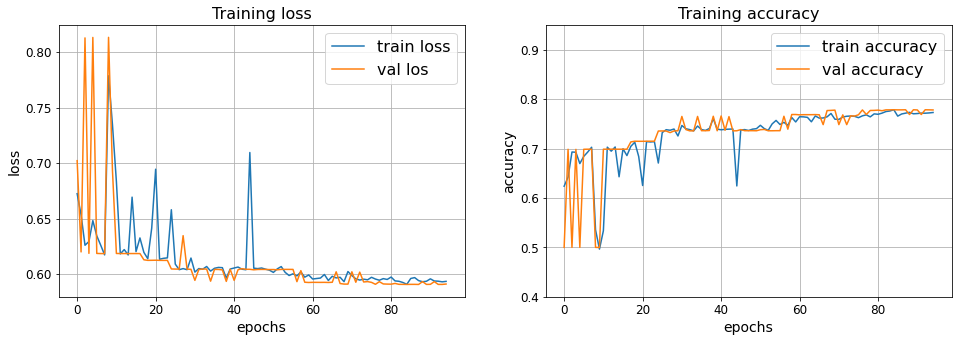

In [83]:
# Training curve
import matplotlib.pyplot as plt
plot.dual_train_curve(history['train_loss'], history['val_loss'], 
      history['train_acc'], history['val_acc'])

In [84]:
print('Evaluation on train dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, train_dataset)
print('Evaluation on val dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, val_dataset)
print('Evaluation on test dataset:')
(te_acc, te_p, te_r) = naive_evaluate(model, test_dataset)

print('\nFor logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r')
print(len(history['train_loss']), history['train_loss'][-1],tr_acc, tr_p, tr_r, te_acc, te_p, te_r)

Evaluation on train dataset:
Acc: 77.90%, P: 95.66%, R: 58.47%
Evaluation on val dataset:
Acc: 77.81%, P: 95.03%, R: 58.17%
Evaluation on test dataset:
Acc: 77.27%, P: 94.96%, R: 57.66%

For logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r
95 0.5934051 0.7781132 0.9502729 0.58166295 0.7727431 0.94963324 0.57660335


### Eval in detail

Converted P/R. 

In [0]:
from sklearn import metrics
print('Test data shape:',x_test.shape, y_test.shape)
# confusion matrix
faulty_thres = 0.5

y_prob = model((x_test, ts_test)).numpy()
y_pred = y_prob >= faulty_thres
result = [a==b for a,b in zip(y_pred, y_test)]
print('At threshold {}, accuracy: {:.2%}'.format(faulty_thres, metrics.accuracy_score(y_test, y_prob >= faulty_thres)))
conf_mtx = confusion_matrix(y_test, y_pred)
conf_mtx

Test data shape: (6736, 250) (6736,)
At threshold 0.5, accuracy: 77.24%


array([[3265,  103],
       [1430, 1938]])

In [0]:
# convert to real world scale

fault_ratio = 16838/575061     # faulty rate in real world
real_n = 575061       # total sample in real dataset
real_1 = 16838
real_0 = real_n - real_1
conf_mtx_cvt = np.zeros([2,2])
conf_mtx_cvt[0,0] = real_0 / (conf_mtx[0,0] + conf_mtx[0,1]) * conf_mtx[0,0]
conf_mtx_cvt[0,1] = real_0 / (conf_mtx[0,0] + conf_mtx[0,1]) * conf_mtx[0,1]
conf_mtx_cvt[1,0] = real_1 / (conf_mtx[1,0] + conf_mtx[1,1]) * conf_mtx[1,0]
conf_mtx_cvt[1,1] = real_1 / (conf_mtx[1,0] + conf_mtx[1,1]) * conf_mtx[1,1]

acc = (conf_mtx_cvt[0,0] + conf_mtx_cvt[1,1]) / conf_mtx_cvt.sum()
p = conf_mtx_cvt[1,1] / (conf_mtx_cvt[0,1] + conf_mtx_cvt[1,1])
r = conf_mtx_cvt[1,1] / (conf_mtx_cvt[1,0] + conf_mtx_cvt[1,1])
print('Converted acc, precision, recall: {:.2%}, {:.2%}, {:.2%}'.format(acc,p,r))

conf_mtx_cvt.round().astype('int')


Converted acc, precision, recall: 95.79%, 36.21%, 57.54%


array([[541151,  17072],
       [  7149,   9689]])

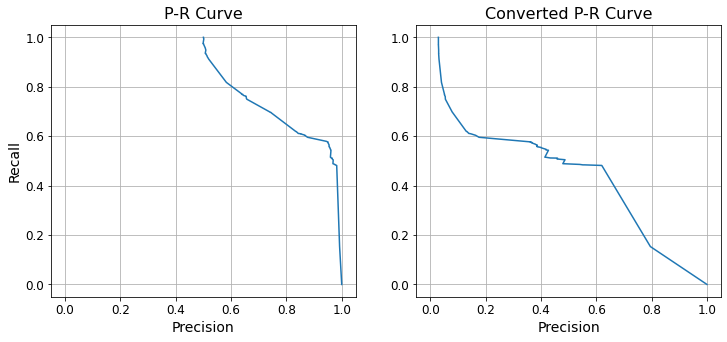

In [0]:
from sklearn.metrics import precision_recall_curve
pr, rc, thresholds = precision_recall_curve(y_test, y_prob, pos_label=1)

# Calculate converted metrics, the mathy way
k = 558223/16838
pr_cvrt = []
for p in pr:
  pr_cvrt.append(1/(k*(1/p-1)+1))
pr_cvrt = np.array(pr_cvrt)

# Converted P-R curve
plot.dual_pr_curve(pr, rc, pr_cvrt, rc)

## CNN + RNN Model

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(
    vocab_size+1, embedding_dims,    # +1 because of padding 0
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, input_length=250),  # input_length=input_length
  tf.keras.layers.Conv1D(filters=32, kernel_size=8, strides=3),
  # tf.keras.layers.LSTM(units=64, return_sequences=True),
  tf.keras.layers.LSTM(units=64, return_sequences=False),
  tf.keras.layers.Dense(units=32, activation='tanh'),
  tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 16)           784       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 81, 32)            4128      
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 31,857
Trainable params: 31,073
Non-trainable params: 784
_________________________________________________________________


### Metrics

Hyper parameters: Adam/RMSprop/..., learning_rate.  RNN seems to prefer RSMprop.


In [0]:
# define metrics, to display during training
train_loss = tf.keras.metrics.Mean()
train_metrics = {
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    'precision': tf.keras.metrics.Precision(),
    'recall': tf.keras.metrics.Recall(),
    }
val_metrics = {
    'loss': tf.keras.metrics.Mean(),
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    }
# training history and curve
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

# define other training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)   #Adam, RMSprop,SGD
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Training

Hyper parameters: early stopping threshold, accuracy threshold.

In [0]:
# start training
print('Start training with {} samples, validate with {} samples'.format(train_size, val_size))
epochs = 1000   # will run 3 hours worst case.
for epoch in range(epochs):
  start = time()
  
  # reset metrics
  train_loss.reset_states()
  for metric in train_metrics.values():
    metric.reset_states()
  for metric in val_metrics.values():
    metric.reset_states()

  for x_batch, ts_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:     # watch_accessed_variables=False
      y_pred = model(x_batch)  # ((x_batch, ts_batch))
      y_pred = tf.squeeze(y_pred, 1)   # make it same dimension as y

      # Loss value for this minibatch
      loss = loss_fn(y_batch, y_pred)
      loss += sum(model.losses)  # must have, what does this do?
      
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update metrics
    train_loss.update_state(loss)
    for metric in train_metrics.values():
        metric.update_state(y_batch, y_pred)
    # print('~', end='')
  
  # update val metrics
  if val_size != 0:
    for x_batch, ts_batch, y_batch in val_dataset:
      y_val_pred = model(x_batch)
      y_val_pred = tf.squeeze(y_val_pred, 1)
      loss = loss_fn(y_batch, y_val_pred)
      val_metrics['loss'].update_state(loss)
      val_metrics['accuracy'].update_state(y_batch, y_val_pred)
  
  # log 
  history['train_loss'].append(train_loss.result().numpy())
  history['train_acc'].append(train_metrics['accuracy'].result().numpy())
  history['val_loss'].append(val_metrics['loss'].result().numpy())
  history['val_acc'].append(val_metrics['accuracy'].result().numpy())

  print_train_info_v2(epoch, time()-start, history)

  # determine early stopping
  # sometimes the loss goes up for a short period, do nothing and wait.
  # stops only when it's absolutely flat.
  
  w = 10     # early stopping moving average window
  n = 5     # early stopping hesitate epochs
  thres = 0.0001        # loss difference threshold
  acc_thres = 0.75   # absolute loss threshold

  if epoch >= n+w+1:
    # loss moving average of the last few epochs
    loss_MA = [history['train_loss'][i-w:i] for i in range(epoch-n, epoch+1)]
    loss_MA = [sum(values) / w for values in loss_MA]
    acc_MA = [history['train_acc'][i-w:i] for i in range(epoch-n, epoch+1)]
    acc_MA = [sum(values) / w for values in acc_MA]
    # for the last n losses, must be going down, and diff < thres
    train_stopping = [abs(a-b)<=thres for (a,b) in zip(loss_MA[0:-1], loss_MA[1:])]
    if sum(train_stopping) == n and acc_MA[-1] >= acc_thres:
      print('Early stopping triggered.')
      print_train_info_v2(epoch, time()-start, history)
      break
  
  # save weights every epoch
  if epoch % 10 == 0: model.save_weights('./checkpoints/my_checkpoint')

Start training with 21552 samples, validate with 5388 samples
epoch 0 - 2s. train_loss: 0.6383 train_acc: 64.11% val_loss: 0.6187 val_acc: 69.87% 
epoch 1 - 2s. train_loss: 0.6174 train_acc: 70.29% val_loss: 0.6185 val_acc: 69.87% 
epoch 2 - 2s. train_loss: 0.6175 train_acc: 70.21% val_loss: 0.6184 val_acc: 69.87% 
epoch 3 - 2s. train_loss: 0.6169 train_acc: 70.41% val_loss: 0.6185 val_acc: 69.87% 
epoch 4 - 2s. train_loss: 0.6175 train_acc: 70.21% val_loss: 0.6184 val_acc: 69.87% 
epoch 5 - 2s. train_loss: 0.6174 train_acc: 70.21% val_loss: 0.6184 val_acc: 69.89% 
epoch 6 - 2s. train_loss: 0.6155 train_acc: 70.85% val_loss: 0.6140 val_acc: 71.02% 
epoch 7 - 2s. train_loss: 0.6087 train_acc: 72.73% val_loss: 0.5923 val_acc: 77.47% 
epoch 8 - 2s. train_loss: 0.5908 train_acc: 77.68% val_loss: 0.5918 val_acc: 77.49% 
epoch 9 - 2s. train_loss: 0.5902 train_acc: 77.79% val_loss: 0.5916 val_acc: 77.53% 
epoch 10 - 2s. train_loss: 0.5902 train_acc: 77.81% val_loss: 0.5917 val_acc: 77.51% 
ep

### Evaluation

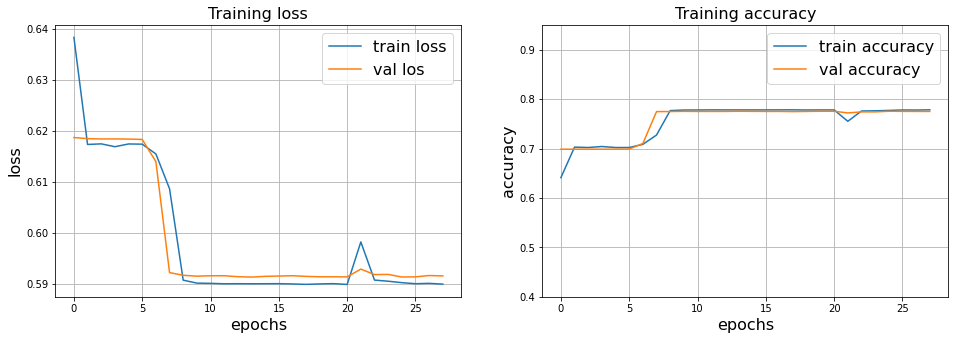

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.legend(['train loss', 'val los'], fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.title('Training loss', fontsize=16)
plt.grid()

plt.subplot(1,2,2)
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.legend(['train accuracy', 'val accuracy'], fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.title('Training accuracy', fontsize=16)
plt.ylim((0.4,0.95))
plt.grid()

In [0]:
print('Evaluation on train dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, train_dataset)
print('Evaluation on val dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, val_dataset)
print('Evaluation on test dataset:')
(te_acc, te_p, te_r) = naive_evaluate(model, test_dataset)

print('\nFor logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r')
print(len(history['train_loss']), history['train_loss'][-1],tr_acc, tr_p, tr_r, te_acc, te_p, te_r)

Evaluation on train dataset:
Acc: 77.84%, P: 96.52%, R: 57.74%
Evaluation on val dataset:
Acc: 77.51%, P: 95.53%, R: 57.16%
Evaluation on test dataset:
Acc: 77.23%, P: 96.04%, R: 56.86%

For logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r
28 0.5900246 0.77509475 0.95533496 0.5716407 0.77230906 0.96038115 0.5685867


In [0]:
# reconstruct test data
x_test = []
ts_test = []
y_test = []
for x_batch, ts_batch, y_batch in test_dataset:
  x_test.append(x_batch)
  ts_test.append(ts_batch)
  y_test.append(y_batch)
x_test = np.concatenate(x_test)
ts_test = np.concatenate(ts_test)
y_test = np.concatenate(y_test)

print('Test data shape:',x_test.shape, y_test.shape)

# confusion matrix
y_pred = model.predict_classes(x_test)
result = [a==b for a,b in zip(y_pred, y_test)]
confusion_matrix(y_test, y_pred)

Test data shape: (6736, 250) (6736,)


array([[3289,   79],
       [1453, 1915]])

### Eval in detail

Converted P/R. 

In [0]:
print('Test data shape:',x_test.shape, y_test.shape)
# confusion matrix
y_pred = model.predict_classes(x_test)
result = [a==b for a,b in zip(y_pred, y_test)]
conf_mtx = confusion_matrix(y_test, y_pred)
conf_mtx

Test data shape: (6736, 250) (6736,)


array([[3289,   79],
       [1453, 1915]])

In [0]:
# convert to real world scale

fault_ratio = 16838/575061     # faulty rate in real world
real_n = 575061       # total sample in real dataset
real_1 = 16838
real_0 = real_n - real_1
conf_mtx_cvt = np.zeros([2,2])
conf_mtx_cvt[0,0] = real_0 / (conf_mtx[0,0] + conf_mtx[0,1]) * conf_mtx[0,0]
conf_mtx_cvt[0,1] = real_0 / (conf_mtx[0,0] + conf_mtx[0,1]) * conf_mtx[0,1]
conf_mtx_cvt[1,0] = real_1 / (conf_mtx[1,0] + conf_mtx[1,1]) * conf_mtx[1,0]
conf_mtx_cvt[1,1] = real_1 / (conf_mtx[1,0] + conf_mtx[1,1]) * conf_mtx[1,1]

acc = (conf_mtx_cvt[0,0] + conf_mtx_cvt[1,1]) / conf_mtx_cvt.sum()
p = conf_mtx_cvt[1,1] / (conf_mtx_cvt[0,1] + conf_mtx_cvt[1,1])
r = conf_mtx_cvt[1,1] / (conf_mtx_cvt[1,0] + conf_mtx_cvt[1,1])
print('Converted acc, precision, recall: {:.1%}, {:.1%}, {:.1%}'.format(acc,p,r))

conf_mtx_cvt.round().astype('int')


Converted acc, precision, recall: 96.5%, 42.2%, 56.9%


array([[545129,  13094],
       [  7264,   9574]])

## Check results

a play ground to make fancy presentations.

In [0]:
# confusion matrix
y_pred = model.predict_classes(x_test)
result = [a==b for a,b in zip(y_pred, y_test)]
confusion_matrix(y_test, y_pred)

array([[3289,   79],
       [1453, 1915]])

Find the error prediction with regard to length.

In [0]:
err_cnt_by_len = [0] * 251
cor_cnt_by_len = [0] * 251
for _x, _r in zip(x_test, result):
  if _x[0] != 0: length=250
  else: length = np.where(_x[::-1]==0)[0][0]
  err_cnt_by_len[length] += int(~_r)
  cor_cnt_by_len[length] += int(_r)

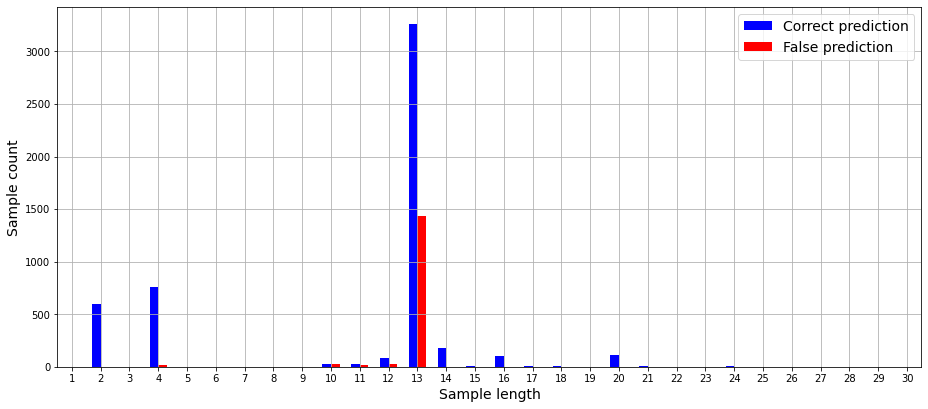

In [0]:
X = np.arange(251)
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X-0.15, cor_cnt_by_len, color = 'b', width = 0.3)
ax.bar(X+0.15, err_cnt_by_len, color = 'r', width = 0.3)
ax.set_xticks(np.arange(0,51))
ax.set_xlim(0.5,30.5)
ax.legend(['Correct prediction', 'False prediction'], fontsize=14)
ax.set_xlabel('Sample length', fontsize=14)
ax.set_ylabel('Sample count', fontsize=14)
ax.grid()

In [0]:
# examine false predictions' probability
y_prob = model.predict(x_test)
print('False predictions:')
for _y, _true, _r in zip(y_prob, y_test, result):
  if _r == False:
    print('Truth {}, prediction: {:.4f}'.format(_true, _y[0]))

## Save/load centre
Codes that save models and results in google drive

### Save P-R curve

CNN

In [0]:
# save the P-R curve values for combined plotting
import pickle
path = '/content/drive/My Drive/time_sequence_alchemy/pr_curve/'
pkl_fn = 'CNN.pkl'
curve_val = {
    'pr': pr,
    'rc': rc,
    'thres': thresholds,
    'pr_cvrt': pr_cvrt,
    'rc_cvrt': rc}
with open(path+pkl_fn, 'wb') as f:
  pickle.dump(curve_val,f)

RNN

In [0]:
# save the P-R curve values for combined plotting
import pickle
path = '/content/drive/My Drive/time_sequence_alchemy/pr_curve/'
pkl_fn = 'RNN.pkl'
curve_val = {
    'pr': pr,
    'rc': rc,
    'thres': thresholds,
    'pr_cvrt': pr_cvrt,
    'rc_cvrt': rc}
with open(path+pkl_fn, 'wb') as f:
  pickle.dump(curve_val,f)

### Save models

Zip and save CNN model

In [0]:
!zip -r "/content/drive/My Drive/time_sequence_alchemy/trained_model/CNN.zip" /content/checkpoints

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/my_checkpoint.data-00000-of-00002 (deflated 28%)
  adding: content/checkpoints/checkpoint (deflated 49%)
  adding: content/checkpoints/my_checkpoint.index (deflated 55%)
  adding: content/checkpoints/my_checkpoint.data-00001-of-00002 (deflated 7%)


Zip and save RNN model

In [0]:
!zip -r "/content/drive/My Drive/time_sequence_alchemy/trained_model/RNN.zip" /content/checkpoints

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/my_checkpoint.data-00000-of-00002 (deflated 28%)
  adding: content/checkpoints/checkpoint (deflated 49%)
  adding: content/checkpoints/my_checkpoint.index (deflated 55%)
  adding: content/checkpoints/my_checkpoint.data-00001-of-00002 (deflated 7%)


### Load models

In [0]:
model.load_weights('./checkpoints/my_checkpoint')